In [5]:
#!/usr/bin/env python3

import glob
import os
from os.path import join
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch 
from dataset_utils import MoNuSegDataset
from model import CNN3
from PIL import Image 

In [3]:
train = True
ROOT = '/share/DEEPLEARNING/datasets/monuseg/'
TRAIN_IMG = join(ROOT,'MoNuSegTrainingData')
TEST_IMG = join(ROOT,'MoNuSegTestData')
if train:
    IMGS_DIR = join(TRAIN_IMG,'Tissue_Images')
    MASKS_DIR = join(TRAIN_IMG,'Binary_masks')
    OUTPUT_DIR = join(TRAIN_IMG,'Output')
else:
    IMGS_DIR = join(TEST_IMG,'Tissue_Images')
    MASKS_DIR = join(TEST_IMG,'Binary_masks')
    OUTPUT_DIR = join(TEST_IMG,'Output')


In [10]:
MODEL_DIR = '/share/homes/karmimy/equiv/save_model/fully_supervised_monuseg/7'
MODEL_NAME = 'fully_supervised_monuseg.pt'

In [25]:
test_dataset = MoNuSegDataset(ROOT,image_set='test')
device = torch.device("cpu")

In [26]:
model = torch.load(join(MODEL_DIR,MODEL_NAME))
model.to(device)

CNN3(
  (conv): Sequential(
    (0): Conv2d(3, 25, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.1, inplace=False)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Dropout2d(p=0.2, inplace=False)
    (7): Conv2d(50, 80, kernel_size=(4, 4), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
  )
  (conv_classif): Sequential(
    (0): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): Conv2d(80, 4, kernel_size=(1, 1), stride=(1, 1))
  )
  (upsampling): Sequential(
    (0): UpsamplingBilinear2d(scale_factor=3.0, mode=bilinear)
  )
)

In [27]:
i,m = test_dataset.__getitem__(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


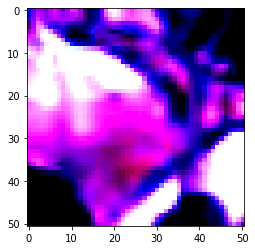

In [28]:
i_copy = i.detach().clone()
plt.imshow(i_copy.transpose(0,2).transpose(0,1))

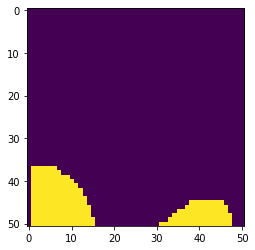

In [29]:
plt.imshow(np.array(m))

In [37]:
pred = model(i.unsqueeze(0))

In [38]:
pred = pred.squeeze().argmax(dim=0)
pred.size()

torch.Size([51, 51])

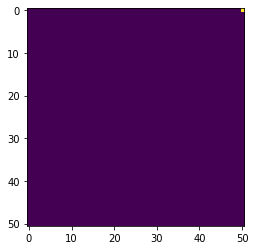

In [39]:
plt.imshow(pred)

In [40]:
torch.unique(pred)

tensor([0, 1])